# Github Performance Metrics- Pull Requests

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../../comm_cage.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['move2kube']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[30740]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

### Query for Pull Request Analysis

In [5]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					pr.pull_request_id AS pull_request, 
					pr.pr_created_at AS created, 
					pr.pr_closed_at AS closed,
					pr.pr_merged_at  AS merged 
                FROM
                	repo r,
                    pull_requests pr
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr.head()

,repo_name,pull_request,created,closed,merged
0,move2kube,27277,2020-09-18 20:18:03,2020-09-18 20:18:47,2020-09-18 20:18:47
1,move2kube,27278,2020-09-18 22:09:58,2020-09-18 22:19:40,2020-09-18 22:19:40
2,move2kube,27279,2020-09-18 22:22:55,2020-09-18 22:23:17,2020-09-18 22:23:17
3,move2kube,27280,2020-09-19 04:55:44,2020-09-19 05:05:50,2020-09-19 05:05:50
4,move2kube,27281,2020-09-19 11:19:29,2020-09-19 15:01:47,2020-09-19 15:01:47


In [6]:
df_pr_comments = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
                    prm.pull_request_id,
                    prm.pr_msg_ref_id,
                    pr.pr_created_at,
                    m.msg_timestamp msg_time,
					m.msg_text comment_text
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_message_ref prm, 
                    message m 
                WHERE
                	m.msg_id = prm.msg_id AND
                    prm.pull_request_id = pr.pull_request_id AND
                	pr.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr_comments = pd.concat([df_pr_comments, df_current_repo])

df_pr_comments = df_pr_comments.reset_index()
df_pr_comments.drop("index", axis=1, inplace=True)
        
df_pr_comments.head()

,repo_name,pull_request_id,pr_msg_ref_id,pr_created_at,msg_time,comment_text
0,move2kube,27283,33243,2020-09-21 17:55:50,2020-09-21 18:05:19,# [Codecov](https://codecov.io/gh/konveyor/mov...
1,move2kube,27284,33244,2020-09-25 08:11:52,2020-09-25 08:29:27,# [Codecov](https://codecov.io/gh/konveyor/mov...
2,move2kube,27285,33245,2020-09-25 09:22:08,2020-09-25 09:38:35,# [Codecov](https://codecov.io/gh/konveyor/mov...
3,move2kube,27298,33246,2020-10-01 21:20:41,2020-10-02 03:55:36,Thanks @Ocramoi for the pull request. Much app...
4,move2kube,27298,33247,2020-10-01 21:20:41,2020-10-02 03:56:49,Sure! I'll get right to it.


In [7]:
df_pr_focus = df_pr
repo_focus = 'move2kube'

In [8]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
#repo_focus = 'augur'
#df_pr_focus = df_pr[df_pr['repo_name'] == repo_focus]

## Median Time to Close/Merge

In [9]:
df_pr_closed = df_pr_focus[df_pr_focus['merged'].isnull()]
df_pr_merged = df_pr_focus[df_pr_focus['merged'].notna()]

df_pr_closed['time_to_close'] = (df_pr_closed.closed - df_pr_closed.created)
df_pr_merged['time_to_merge'] = (df_pr_merged.merged - df_pr_merged.created)

In [10]:
df_pr_closed_monthly = df_pr_closed['time_to_close'].groupby(df_pr_closed.created.dt.to_period("M")).agg('median')
df_pr_merged_monthly = df_pr_merged['time_to_merge'].groupby(df_pr_merged.created.dt.to_period("M")).agg('median')

In [11]:
df_pr_merged_monthly.head()

created
2020-09          0 days 00:00:26
2020-10   0 days 00:16:00.500000
2020-11          0 days 00:16:55
2020-12   0 days 00:10:58.500000
2021-01          0 days 00:45:58
Freq: M, Name: time_to_merge, dtype: timedelta64[ns]

### Time Granularity and Normalization

We can visualize the trend in median time to close/merge PRs by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the `log` of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the median time to close/merge PRs.

In [12]:
# days
df_pr_closed_monthly_days = df_pr_closed_monthly.astype('timedelta64[D]')
df_pr_merged_monthly_days = df_pr_merged_monthly.astype('timedelta64[D]')
# hours
df_pr_closed_monthly_hours = df_pr_closed_monthly.astype('timedelta64[h]')
df_pr_merged_monthly_hours = df_pr_merged_monthly.astype('timedelta64[h]')
# minutes
df_pr_closed_monthly_minutes = df_pr_closed_monthly.astype('timedelta64[m]')
df_pr_merged_monthly_minutes = df_pr_merged_monthly.astype('timedelta64[m]')
# seconds
df_pr_closed_monthly_seconds = df_pr_closed_monthly.astype('timedelta64[s]')
df_pr_merged_monthly_seconds = df_pr_merged_monthly.astype('timedelta64[s]')

We can now proceed to normalizing the values

In [13]:
# Normalize PRs closed
df_pr_closed_monthly_days_norm = np.log(df_pr_closed_monthly_days)
df_pr_closed_monthly_hours_norm = np.log(df_pr_closed_monthly_hours)
df_pr_closed_monthly_minutes_norm = np.log(df_pr_closed_monthly_minutes)
df_pr_closed_monthly_seconds_norm = np.log(df_pr_closed_monthly_seconds)
# Normalize PRs merged
df_pr_merged_monthly_days_norm = np.log(df_pr_merged_monthly_days)
df_pr_merged_monthly_hours_norm = np.log(df_pr_merged_monthly_hours)
df_pr_merged_monthly_minutes_norm = np.log(df_pr_merged_monthly_minutes)
df_pr_merged_monthly_seconds_norm = np.log(df_pr_merged_monthly_seconds)

## Line Plot

We will now consider the granularity level to be "days" and plot the median time to close/merge PRs grouped by months.

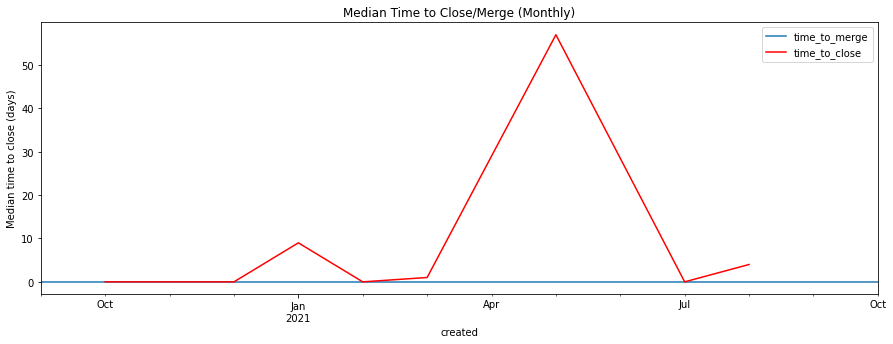

In [14]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly_days.plot(kind='line',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly_days.plot(kind='line',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

PRs can be merged/closed within seconds/minutes/hours/days, hence it is important to consider all possible time units for better visualizations. We can further expand the above line graph by plotting a bar graph with the normalized log values.

## Bar Plot

Let's plot the bar graph for different time granularity levels by considering the normalized log values to attain a better perspective.

#### Median Time in Days

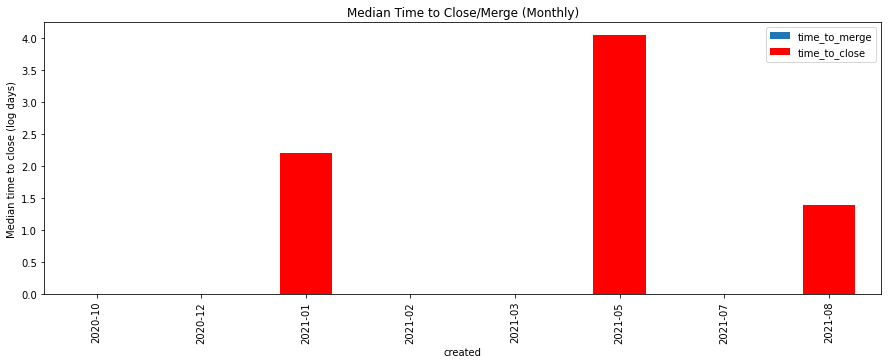

In [15]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to close (log days)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly_days_norm.plot(kind='bar',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly_days_norm.plot(kind='bar',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

From the above graph we see that there are a few missing values which can be misleading, hence its worthwhile to explore the median time in other time units such as hours, seconds or minutes.

#### Median Time in Hours

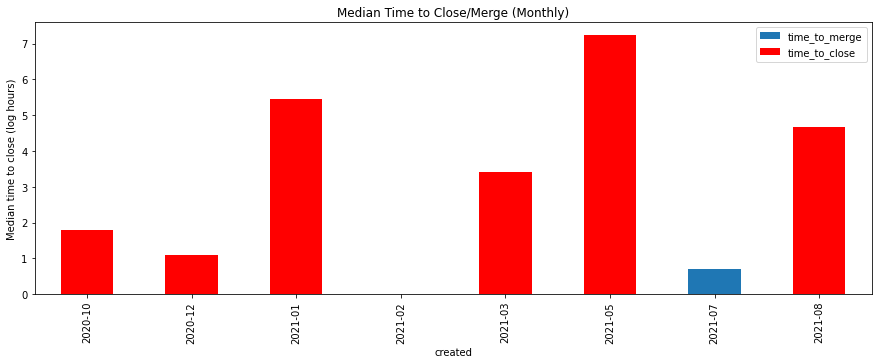

In [16]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to close (log hours)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly_hours_norm.plot(kind='bar',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly_hours_norm.plot(kind='bar',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

#### Median Time in Minutes

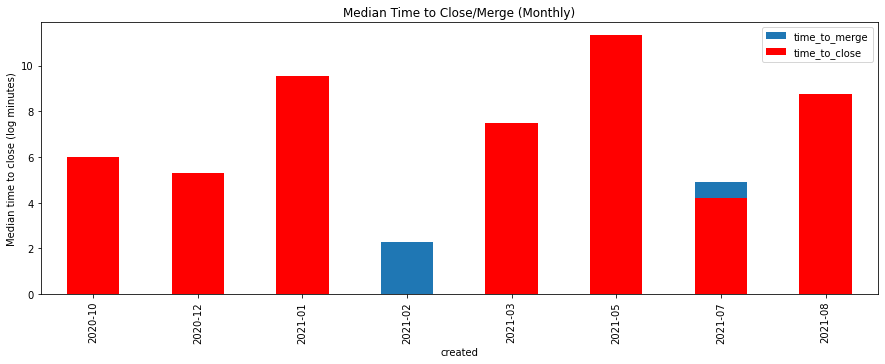

In [17]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to close (log minutes)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly_minutes_norm.plot(kind='bar',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly_minutes_norm.plot(kind='bar',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

#### Median Time in Seconds

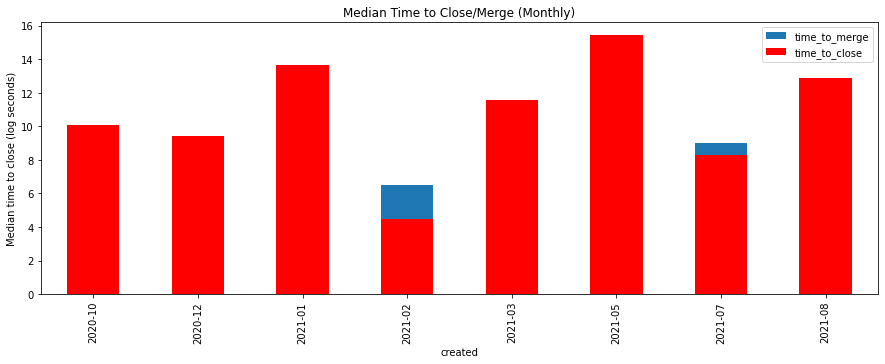

In [18]:
ax = plt.gca()

plt.xlabel("Month")
plt.ylabel("Median time to close (log seconds)")
plt.title("Median Time to Close/Merge (Monthly)")

df_pr_merged_monthly_seconds_norm.plot(kind='bar',x='created',y='time_to_merge',ax=ax,legend = True)
df_pr_closed_monthly_seconds_norm.plot(kind='bar',x='created',y='time_to_close', color='red', ax=ax,legend = True)
plt.show()

## Monthly PRs Close/Merged

Let's now plot the number of PRs closed/merged monthly

In [19]:
df_pr_c_m_monthly = df_pr_focus[['merged','closed']].groupby(df_pr.closed.dt.to_period("M")).agg('count')

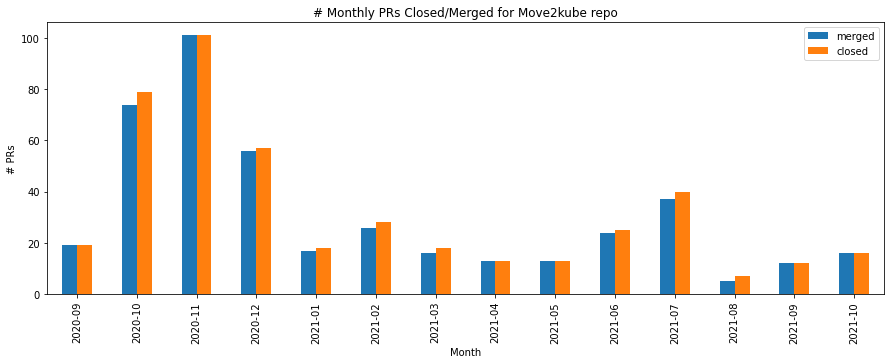

In [20]:
df_pr_c_m_monthly.plot.bar()

plt.xlabel("Month")
plt.ylabel("# PRs")
plt.title("# Monthly PRs Closed/Merged for "+repo_focus.capitalize() +" repo")
plt.show()

From the above graph, we see that for the `augur` repo highest number of PRs were merged/closed in March 2020.

## Percent pull requests merged vs not 

Let us now find out what percentage of the PRs were merged and not merged.

In [21]:
df_pr_compare = df_pr_focus.dropna(subset=['closed'])
df_pr_compare["merged_in"] = False
df_pr_compare["merged_in"] = df_pr_compare["merged_in"].where(df_pr_compare["merged"].isna(),other= True)

In [22]:
percent = df_pr_compare["pull_request"].groupby(df_pr_compare.merged_in).agg('count')

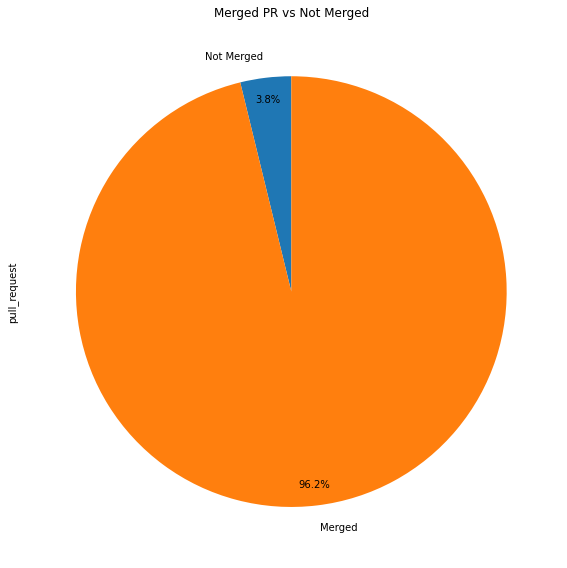

In [23]:
labels = ["Not Merged","Merged"]
percent.plot.pie(figsize=(15,8),autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Merged PR vs Not Merged")
plt.tight_layout()
plt.show()

From the above graph, we see that ~82% of the PRs were merged in the `augur` repo.

## Time to First Response PR

Let's now identify the time taken for a first response in a PR.

In [24]:
df_pr_comments_focus = df_pr_comments[df_pr_comments['repo_name'] == repo_focus]
df_pr_comments_focus = df_pr_comments_focus.sort_values(by= "msg_time")
df_pr_comments_focus = df_pr_comments_focus.reset_index(drop=True)
df_pr_comments_focus = df_pr_comments_focus.drop_duplicates(subset='pull_request_id', keep='first')

In [25]:
not_answered = df_pr_focus.shape[0]-df_pr_comments_focus.shape[0]
answered = df_pr_comments_focus.shape[0]

### Pie Chart: Reponse Percent

We can visualize the response percentage by plotting a pie chart.

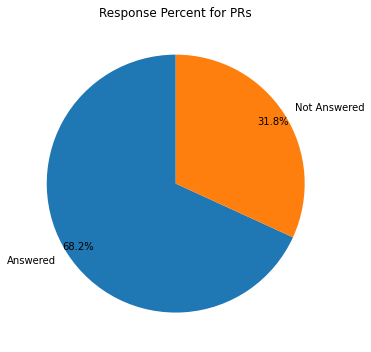

In [26]:
labels = ["Answered","Not Answered"]
sizes = [answered,not_answered]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Response Percent for PRs")
plt.tight_layout()
plt.show()

From the above pie chart, we see that ~74% of the PRs response in the `augur` repo were not answered.

### Pie Chart: Bot Percent

We can visualize the amount of first resopnses by bots by plotting a pie chart. There is not a direct way of doing this so we are taking the time of how quickly bots normally respond to a PR. This is a naive approach and will be iterated on

In [27]:
df_pr_comments_focus['time_to_response'] = (df_pr_comments_focus.msg_time - df_pr_comments_focus.pr_created_at)
#df_pr_comments_focus = df_pr_comments_focus[df_pr_comments_focus['time_to_response'] >= pd.Timedelta(0)]

In [28]:
df_pr_bot = df_pr_comments_focus[df_pr_comments_focus['time_to_response'] <= pd.Timedelta(21,unit='m')]

In [29]:
people = df_pr_comments_focus.shape[0]-df_pr_bot.shape[0]
bots = df_pr_bot.shape[0]

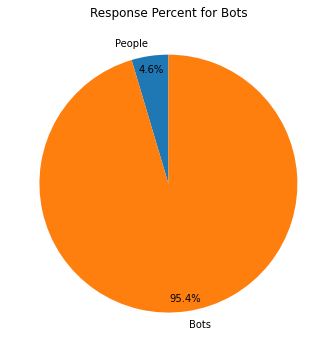

In [30]:
labels = ["People","Bots"]
sizes = [people,bots]
plt.pie(sizes,autopct='%1.1f%%',startangle=90,pctdistance=0.9,labels=labels)
plt.title("Response Percent for Bots")
plt.tight_layout()
plt.show()

### Bar Chart: Mean Time To First Reponse

In [31]:
df_pr_comments_monthly = df_pr_comments_focus['time_to_response'].groupby(df_pr_comments_focus.pr_created_at.dt.to_period("M")).agg('mean')

#### Time Granularity and Normalization

We can visualize the trend in median time of first response by month. However, in order to best capture all the median values including the outliers we can normalize the data by taking the `log` of the values before plotting. We should also consider the level of granularity we would like to capture and visualize the median time in i.e. days vs hours vs minutes vs seconds.

Let us first consider the different levels of granularity for the mean time to first response.

In [32]:
# days
df_pr_comments_monthly_days = df_pr_comments_monthly.astype('timedelta64[D]')
# hours
df_pr_comments_monthly_hours = df_pr_comments_monthly.astype('timedelta64[h]')
# minutes
df_pr_comments_monthly_minutes = df_pr_comments_monthly.astype('timedelta64[m]')
# seconds
df_pr_comments_monthly_seconds = df_pr_comments_monthly.astype('timedelta64[s]')

We can now proceed to normalizing the values

In [33]:
df_pr_comments_monthly_days_norm = np.log(df_pr_comments_monthly_days)
df_pr_comments_monthly_hours_norm = np.log(df_pr_comments_monthly_hours)
df_pr_comments_monthly_minutes_norm = np.log(df_pr_comments_monthly_minutes)
df_pr_comments_monthly_seconds_norm = np.log(df_pr_comments_monthly_seconds)

We will now consider the different granularity levels of time i.e. days, hours, minutes and seconds and plot the mean time to first response grouped by months.

#### Mean Time in Days

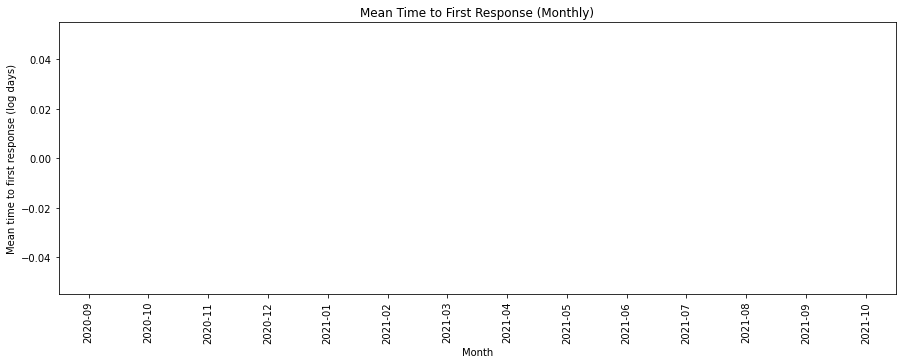

In [34]:
df_pr_comments_monthly_days_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean time to first response (log days)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

From the above graph we see that there are a few missing values which can be misleading, hence its worthwhile to explore the mean time in other time units such as hours, seconds or minutes.

#### Mean Time in Hours

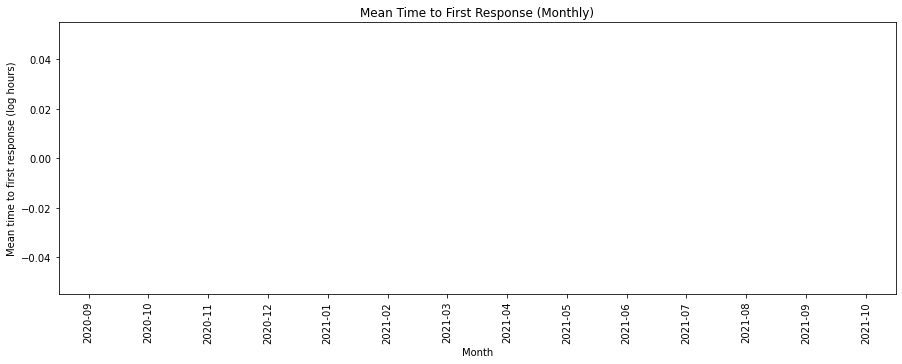

In [35]:
df_pr_comments_monthly_hours_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean time to first response (log hours)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

#### Mean Time in Minutes

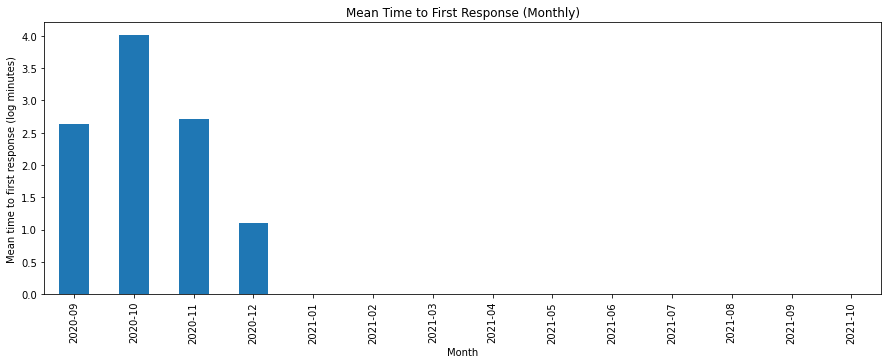

In [36]:
df_pr_comments_monthly_minutes_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean time to first response (log minutes)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

#### Mean Time in Seconds

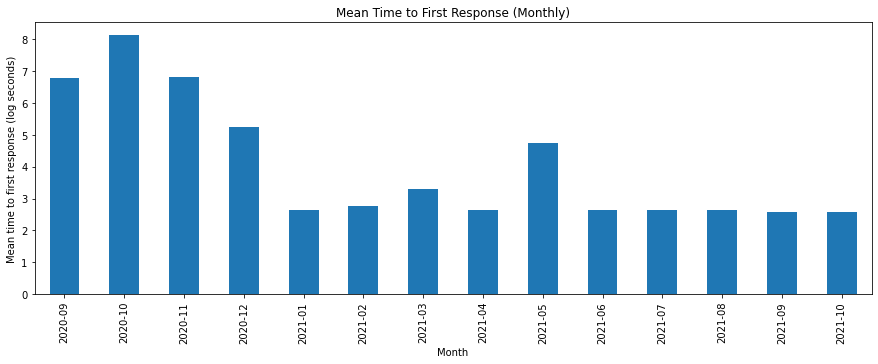

In [37]:
df_pr_comments_monthly_seconds_norm.plot.bar()
plt.xlabel("Month")
plt.ylabel("Mean time to first response (log seconds)")
plt.title("Mean Time to First Response (Monthly)")
plt.show()

In [38]:
df_pr_comments_focus.describe()

,pull_request_id,pr_msg_ref_id,time_to_response
count,304.000000,304.000000,304
mean,27531.365132,33495.388158,0 days 00:10:51.828947368
std,123.584640,158.265205,0 days 01:03:11.206954950
min,27283.000000,33243.000000,0 days 00:00:11
25%,27439.750000,33355.750000,0 days 00:00:14
50%,27545.500000,33475.000000,0 days 00:00:16
75%,27642.250000,33634.250000,0 days 00:08:59.500000
max,27722.000000,33786.000000,0 days 16:54:09


## Conclusion

In this notebook we have visualized some of the performance metrics measured for GitHub PRs and considered different time granularity levels such as days, hours, minutes and seconds to gain a better understanding of the metrics behavior.